<a href="https://colab.research.google.com/github/CRM48/AIML425-A2/blob/main/AllParts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model 1, epoch 0, Loss: 0.6729
Model 1, epoch 500, Loss: 0.0077
Model 1, epoch 1000, Loss: 0.0084
Model 1, epoch 1500, Loss: 0.0041
Model 1, epoch 2000, Loss: 0.0099
Model 1, epoch 2500, Loss: 0.0070
Model 1, epoch 3000, Loss: 0.0047
Model 1, epoch 3500, Loss: 0.0109
Model 1, epoch 4000, Loss: 0.0073
Model 1, epoch 4500, Loss: 0.0071


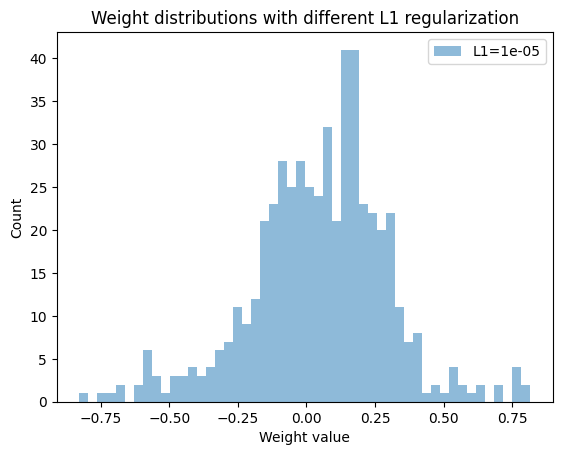

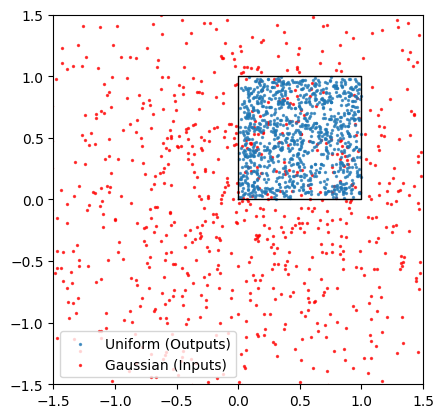

Model 2, epoch 0, Loss: 1.0648
Model 2, epoch 500, Loss: 0.0267
Model 2, epoch 1000, Loss: 0.0127
Model 2, epoch 1500, Loss: 0.0057
Model 2, epoch 2000, Loss: 0.0019
Model 2, epoch 2500, Loss: 0.0030
Model 2, epoch 3000, Loss: 0.0015
Model 2, epoch 3500, Loss: 0.0043
Model 2, epoch 4000, Loss: 0.0015
Model 2, epoch 4500, Loss: 0.0016


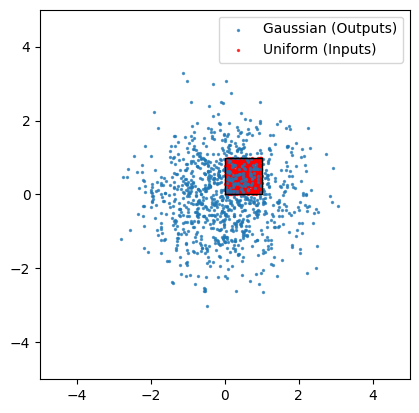

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Model 1, 2D Gaussian to 2D uniform data
class ToUniformModel(nn.Module):
  def __init__(self, activation_function=nn.ReLU()):
    super(ToUniformModel, self).__init__()
    self.net = nn.Sequential(
         nn.Linear(2, 20),
         activation_function,
         nn.Linear(20, 20),
         activation_function,
         nn.Linear(20, 2),
         nn.Sigmoid() # Ensures data is between 0-1
     )

  def forward(self, x):
    return self.net(x)

# Model 2, 2D Uniform to 2D Gaussian data
class ToGaussianModel(nn.Module):
  def __init__(self, activation_function=nn.ReLU()):
    super(ToGaussianModel, self).__init__()
    self.net = nn.Sequential(
         nn.Linear(2, 50),
         activation_function,
         nn.Linear(50, 50),
         activation_function,
         nn.Linear(50, 50),
         activation_function,
         nn.Linear(50, 2) # Output is any real value
     )

  def forward(self, x):
    return self.net(x)


# Computes pairwise Gaussian kernel between two sets of 2D vectors
def gaussian_kernel(x, y, sigma=0.2):
    # Add dimensions to allow for vector operations
    x_exp = x.unsqueeze(1)
    y_exp = y.unsqueeze(0)
    diff = x_exp - y_exp
    dist_sq = torch.sum(diff ** 2, dim=2)
    # Return exp((||x-y||^2) / (2σ^2))
    return torch.exp(-dist_sq / (2 * sigma ** 2))


# Calculates the maximum mean discrepancy loss
# Uses the Gaussian Kernal function above
def mmd_loss(x, y, sigma=0.2):
    Kxx = gaussian_kernel(x, x, sigma)
    Kyy = gaussian_kernel(y, y, sigma)
    Kxy = gaussian_kernel(x, y, sigma)
    ## Return output of mmd loss formula
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()


# Parameters
learning_rate = 0.001
num_epochs = 5000
batch_size = 256
lambda_val = 0.00001
weight_distributions = {}

# Create model and optimizer for second model
gaussian_model = ToGaussianModel(nn.LeakyReLU())
gaussian_optimizer = optim.Adam(gaussian_model.parameters(), lr=learning_rate)


for reg_type in ["none", "l1", "l2"]:
  # Create model and optimizer for first model
  uniform_model = ToUniformModel(nn.LeakyReLU())
  uniform_optimizer = optim.Adam(uniform_model.parameters(), lr=learning_rate)


  # Training for model 1
  for epoch in range(num_epochs):
      # Generate inputs, predictions and uniform distribution
      normal = torch.randn(batch_size, 2)
      uniform = torch.rand(batch_size, 2)
      predictions = uniform_model(normal)

      loss = mmd_loss(predictions, uniform, sigma=0.2)

      # Penalties
      if reg_type == "l1":
        l1_penalty = sum(p.abs().sum() for p in uniform_model.parameters())
        loss += lambda_val * l1_penalty

      if reg_type == "l2":
        l2_penalty = sum((p**2).sum() for p in uniform_model.parameters())
        loss += lambda_val * l2_penalty


      # Backpropogate
      uniform_optimizer.zero_grad()
      loss.backward()
      uniform_optimizer.step()

      """
      if epoch % 500 == 0:
        print(f"Model 1, epoch {epoch}, Loss: {loss.item():.4f}")
      """

  # After training, store weights for visualization
  all_weights = torch.cat([p.flatten() for p in uniform_model.parameters()]).detach().numpy()
  weight_distributions[reg_type] = all_weights

# Plot histograms
plt.figure(figsize=(8, 5))
for reg_type, weights in weight_distributions.items():
    plt.hist(weights, bins=50, alpha=0.5, label=reg_type)

plt.title("Weight distributions using different regularizations")
plt.xlabel("Weight value")
plt.ylabel("Count")
plt.legend()
plt.show()

"""
# Generate predictions using final model
with torch.no_grad():
    normal = torch.randn(1000, 2)
    predictions = uniform_model(normal)

# Plot uniform outputs of model compared to normal distributed inputs
plt.scatter(predictions[:,0], predictions[:,1], label='Uniform (Outputs)', s=2, alpha=0.7, zorder=2)
plt.scatter(normal[:,0], normal[:,1], label='Gaussian (Inputs)', color='red', s=2, alpha=0.7, zorder=1)

plt.plot([0,1,1,0,0], [0,0,1,1,0], color='black', linewidth=1)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


# Training for model 2
for epoch in range(num_epochs):
    # Generate inputs, predictions and uniform distribution
    normal = torch.randn(batch_size, 2)
    uniform = uniform_model(normal).detach()
    predictions = gaussian_model(uniform)

    # Compute loss comparing predictions to uniform distribution
    loss = nn.MSELoss()(predictions, normal)

    # Backpropogate
    gaussian_optimizer.zero_grad()
    loss.backward()
    gaussian_optimizer.step()

    if epoch % 500 == 0:
      print(f"Model 2, epoch {epoch}, Loss: {loss.item():.4f}")

with torch.no_grad():
    normal = torch.randn(1000, 2)
    uniform = uniform_model(normal)
    predictions = gaussian_model(uniform)

# Plot uniform outputs of model compared to uniformly distributed inputs
plt.scatter(predictions[:,0], predictions[:,1], label='Gaussian (Outputs)', s=2, alpha=0.7, zorder=2)
plt.scatter(uniform[:,0], uniform[:,1], label='Uniform (Inputs)', color='red', s=2, alpha=0.7, zorder=1)

plt.plot([0,1,1,0,0], [0,0,1,1,0], color='black', linewidth=1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()
"""